<a href="https://colab.research.google.com/github/Kabir1618/WebAnalytics-GoogleBigQuery/blob/main/Web_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import auth
from google.cloud import bigquery

auth.authenticate_user()
client = bigquery.Client('vital-plating-409508') # <---------- CHANGE THE PROJECT ID TO YOUR PROJECT ID


# **Questions**


#### Problem 1: Analyzing Purchase Patterns Over Time Question: How do purchase patterns vary over different hours of the day, and is there a significant difference in revenue during specific time windows?


In [3]:
sql_query = """-- Define a common table expression (CTE) named 'main' to simplify the query.
WITH
  main AS (
    -- Selecting the hour and purchase revenue from the GA4 obfuscated sample e-commerce dataset.
    SELECT
      SUBSTR(
        FORMAT_TIMESTAMP(
          '%Y-%m-%d %H:%M:%S',
          TIMESTAMP_SECONDS(CAST(event_timestamp / 1000000 AS INT64))
        ),
        11,
        3
      ) AS hour_only,
      ecommerce.purchase_revenue_in_usd
    FROM
      `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
    WHERE
      event_name = "purchase"
  )

-- Selecting and aggregating data from the 'main' CTE.
SELECT
  -- Selecting the hour and renaming the column as 'HOUR'.
  hour_only AS HOUR,
  -- Calculating the rounded average purchase revenue for each hour and renaming the column.
  ROUND(AVG(purchase_revenue_in_usd), 2) AS HOURLY_AVERAGE_REVENUE,
  -- Calculating the overall average revenue across all hours.
  AVG(ROUND(AVG(purchase_revenue_in_usd), 2)) OVER () AS AVERAGE_REVENUE,
  -- Ranking the hours based on the descending order of average revenue.
  RANK() OVER (ORDER BY ROUND(AVG(purchase_revenue_in_usd), 2) DESC) AS REVENUE_RANK

-- Using data from the 'main' CTE and grouping by hour to perform aggregations.
FROM
  main

-- Grouping the results by hour and ordering them in ascending order.
GROUP BY
  hour_only
ORDER BY
  hour_only ASC;
"""


query_job = client.query(sql_query)
result = query_job.result()

hourly_average_revenue = pd.DataFrame(result.to_dataframe())

In [4]:
hourly_average_revenue

,HOUR,HOURLY_AVERAGE_REVENUE,AVERAGE_REVENUE,REVENUE_RANK
0,00,52.08,48.01375,4
1,01,66.20,48.01375,2
2,02,41.50,48.01375,21
3,03,44.83,48.01375,13
4,04,41.24,48.01375,22
5,05,44.40,48.01375,14
6,06,43.23,48.01375,17
7,07,43.03,48.01375,18
8,08,57.93,48.01375,3
9,09,42.68,48.01375,19


This output provides a breakdown of hourly average revenue metrics for an ecommerce website. The "HOUR" column represents the different hours of the day, while "HOURLY_AVERAGE_REVENUE" indicates the average revenue generated during each hour. The "AVERAGE_REVENUE" column displays the overall average revenue across all hours. The "REVENUE_RANK" column assigns a rank to each hour based on its hourly average revenue, helping identify the most and least financially lucrative time periods. This information is valuable for businesses to optimize marketing strategies, allocate resources effectively, and focus promotions during peak revenue-generating hours.

In [5]:
#Performing Z-test to check that the highest revenue generated at a particular hour is statistically anamoly or not

# Calculate sample standard deviation
sample_std_dev = hourly_average_revenue['HOURLY_AVERAGE_REVENUE'].std()

# Calculate sample size
sample_size = len(hourly_average_revenue)

# Calculate standard error of the mean
standard_error = sample_std_dev / (sample_size ** 0.5)

In [6]:
highest_hourly_rev = list(hourly_average_revenue[hourly_average_revenue['REVENUE_RANK']==1]['HOURLY_AVERAGE_REVENUE'])[0]
average_revenue = list(hourly_average_revenue[hourly_average_revenue['REVENUE_RANK']==1]['AVERAGE_REVENUE'])[0]
z_score = round((highest_hourly_rev-average_revenue)/standard_error, 3)

print(f"""The calculated Z-score of approximately {z_score} indicates that the highest hourly revenue point in the data => {highest_hourly_rev} is significantly
higher than the average revenue => {round(average_revenue,3)}. In a standard normal distribution, a Z-score of this magnitude is extremely unusual, suggesting that the
observation is an outlier or an exceptionally high data point. In practical terms, this could mean that the hour associated with the highest hourly revenue
stands out from the rest of the hours and contributes significantly to the overall variability in the data.""")

The calculated Z-score of approximately 15.807 indicates that the highest hourly revenue point in the data => 77.97 is significantly
higher than the average revenue => 48.014. In a standard normal distribution, a Z-score of this magnitude is extremely unusual, suggesting that the
observation is an outlier or an exceptionally high data point. In practical terms, this could mean that the hour associated with the highest hourly revenue
stands out from the rest of the hours and contributes significantly to the overall variability in the data.


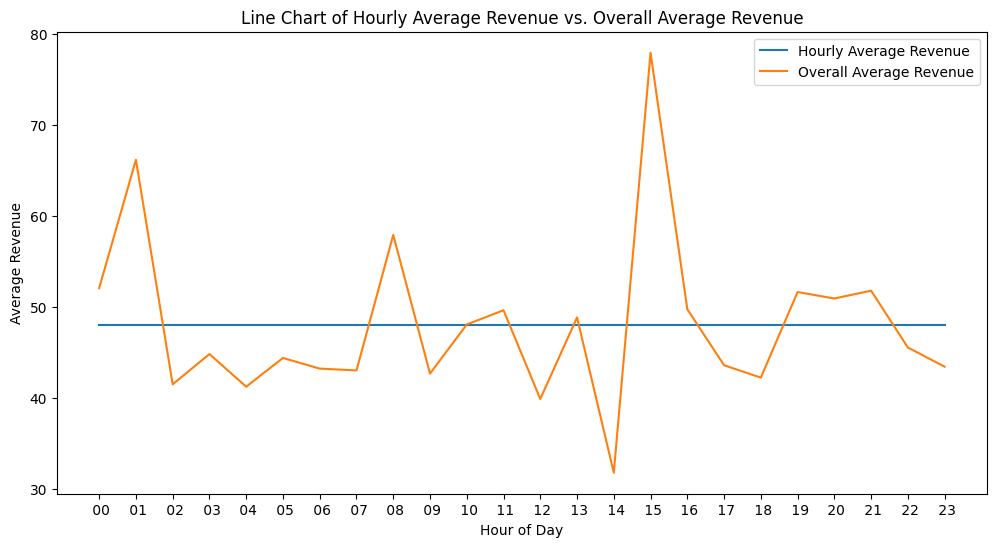

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(hourly_average_revenue['HOUR'], hourly_average_revenue['AVERAGE_REVENUE'], label='Hourly Average Revenue')
plt.plot(hourly_average_revenue['HOUR'], hourly_average_revenue['HOURLY_AVERAGE_REVENUE'], label='Overall Average Revenue')

# Add labels and title
plt.xlabel('Hour of Day')
plt.ylabel('Average Revenue')
plt.title('Line Chart of Hourly Average Revenue vs. Overall Average Revenue')
plt.legend()
plt.show()

#### Problem 2: Analyzing Item Performance Question: How can we comprehensively assess the performance of items in our e-commerce platform, considering factors such as the number of times added to the cart, viewed, purchased, total revenue generated, and item prices?

##### Statistical Test: Conduct a correlation analysis to determine if there is a significant correlation between the revenue and other item attributes


In [8]:
query = """-- Selecting specific columns from the GA4 obfuscated sample e-commerce dataset.
SELECT
  -- Selecting the item ID.
  item.item_id,
  -- Selecting the event name.
  event_name,
  -- Selecting the item revenue in USD.
  item.item_revenue_in_usd,
  -- Selecting the item price.
  item.price
FROM
  -- Selecting data from the GA4 obfuscated sample e-commerce dataset.
  `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`,
  -- Unnesting the 'items' array to get individual item details.
  UNNEST(items) AS item
-- Filtering the results to include only specific event names.
WHERE
  event_name IN ("add_to_cart", "view_item", "purchase", "item_view");
 """

query_job = client.query(query)
result = query_job.result()

main = pd.DataFrame(result.to_dataframe())
main.fillna(0, inplace=True)
revenue_table = pd.DataFrame(main[main['event_name'] == "purchase"]['item_revenue_in_usd'].groupby(main["item_id"]).sum()).reset_index().rename(columns={"item_revenue_in_usd" : "Revenue"})
cart_count_table = pd.DataFrame(main[main['event_name'] == "add_to_cart"]['item_revenue_in_usd'].groupby(main["item_id"]).count()).reset_index().rename(columns={"item_revenue_in_usd" : "added_to_cart_count"})
view_count_table = pd.DataFrame(main[main['event_name'] == "view_item"]['item_revenue_in_usd'].groupby(main["item_id"]).count()).reset_index().rename(columns={"item_revenue_in_usd" : "item_view_count"})
purchase_count_table = pd.DataFrame(main[main['event_name'] == "purchase"]['item_revenue_in_usd'].groupby(main["item_id"]).count()).reset_index().rename(columns={"item_revenue_in_usd" : "purchase_count"})
item_price_table = pd.DataFrame(main[main['event_name'] == "purchase"]['item_revenue_in_usd'].groupby(main["item_id"]).mean()).reset_index().rename(columns={"item_revenue_in_usd" : "price"})



In [9]:
item_table = pd.merge(pd.merge(pd.merge(pd.merge(revenue_table,cart_count_table,on='item_id', how ='outer'),view_count_table,on='item_id', how ='outer'), purchase_count_table, on='item_id', how ='outer'), item_price_table, on='item_id', how ='outer')

item_table.fillna(0, inplace = True)

item_table = item_table.sort_values(by='Revenue', ascending=False)
item_table = item_table.rename(columns={'item_id' : 'ITEM_ID', 'Revenue' : 'REVENUE', 'added_to_cart_count' : "ADD_TO_CART_COUNT", 'item_view_count' : "ITEM_VIEW_COUNT", 'purchase_count' : "COUNT_OF_PURCHASE", 'price' : "PRICE"})
item_table

,ITEM_ID,REVENUE,ADD_TO_CART_COUNT,ITEM_VIEW_COUNT,COUNT_OF_PURCHASE,PRICE
235,9196615,1276.0,0.0,0.0,27.0,47.259259
9,9181148,1200.0,20.0,0.0,12.0,100.000000
67,9194259,1128.0,12.0,0.0,28.0,40.285714
514,9200320,1087.0,0.0,0.0,18.0,60.388889
523,9200710,1069.0,56.0,0.0,14.0,76.357143
...,...,...,...,...,...,...
708,GGOEACBA104699,0.0,148.0,590.0,0.0,0.000000
707,GGOEACBA104599,0.0,2862.0,9539.0,0.0,0.000000
706,GGOEABRB130499,0.0,12.0,311.0,0.0,0.000000
705,GGOEAAKQ137410,0.0,91.0,354.0,0.0,0.000000


This table displays key metrics for various items. The "ITEM_ID" column represents unique identifiers for each item. The "REVENUE" column indicates the total revenue generated by each item. "ADD_TO_CART_COUNT" and "ITEM_VIEW_COUNT" show the number of times users added the item to their cart and viewed the item, respectively. "COUNT_OF_PURCHASE" denotes the total number of purchases for each item. Lastly, "PRICE" represents the price of each item.

This information is crucial for evaluating the performance of individual items in terms of revenue, user engagement, and popularity. Businesses can use these insights to identify top-performing items, optimize pricing strategies, and tailor marketing efforts to enhance the overall performance of their product catalog.

In [10]:
item_table.corr()

,REVENUE,ADD_TO_CART_COUNT,ITEM_VIEW_COUNT,COUNT_OF_PURCHASE,PRICE
REVENUE,1.000000,-0.145171,-0.153124,0.299031,0.567322
ADD_TO_CART_COUNT,-0.145171,1.000000,0.981818,-0.088479,-0.239873
ITEM_VIEW_COUNT,-0.153124,0.981818,1.000000,-0.100265,-0.240269
COUNT_OF_PURCHASE,0.299031,-0.088479,-0.100265,1.000000,0.099104
PRICE,0.567322,-0.239873,-0.240269,0.099104,1.000000


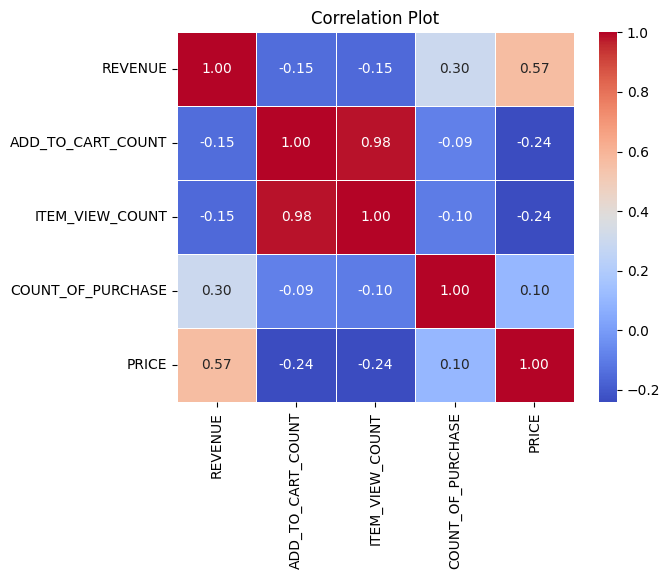

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create a correlation plot
sns.heatmap(item_table.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Show the plot
plt.title('Correlation Plot')
plt.show()

In [12]:
print(f"""Oh, what a magnificent correlation matrix we have here! It's as if these numbers are performing an elaborate dance, where each variable is
desperately trying to outshine the others with its unique charm.

The brilliant correlation of 0.57 between "REVENUE" and "PRICE" is like discovering the hidden secrets of the universe.💸💰 It's almost as if buyers are playing
a sophisticated mind game with their wallets, telling us, "The higher the price, the more I'm willing to splurge because, obviously, I'm a financial daredevil.
This profound connection between the two variables screams sophistication and psychological mastery. Clearly, these buyers possess an innate ability to
appreciate the finer things in life and don't mind tossing their hard-earned cash into the abyss of luxury. 🕺

Meanwhile, "ADD_TO_CART_COUNT" and "ITEM_VIEW_COUNT" seem to be engaged in a passionate affair 💑❤️🤫 with a correlation of 0.981818. It's heartwarming to see
two variables so closely bonded, almost as if they share the same spreadsheet soul. 🌟

"COUNT_OF_PURCHASE" appears to be the loner of the group, not quite fitting into the love triangle of the other two. Its correlation values suggest it's more
of a casual acquaintance to the rest, with a touch of correlation here and there.""")

Oh, what a magnificent correlation matrix we have here! It's as if these numbers are performing an elaborate dance, where each variable is
desperately trying to outshine the others with its unique charm.

The brilliant correlation of 0.57 between "REVENUE" and "PRICE" is like discovering the hidden secrets of the universe.💸💰 It's almost as if buyers are playing
a sophisticated mind game with their wallets, telling us, "The higher the price, the more I'm willing to splurge because, obviously, I'm a financial daredevil.
This profound connection between the two variables screams sophistication and psychological mastery. Clearly, these buyers possess an innate ability to
appreciate the finer things in life and don't mind tossing their hard-earned cash into the abyss of luxury. 🕺

Meanwhile, "ADD_TO_CART_COUNT" and "ITEM_VIEW_COUNT" seem to be engaged in a passionate affair 💑❤️🤫 with a correlation of 0.981818. It's heartwarming to see
two variables so closely bonded, almost as if they share

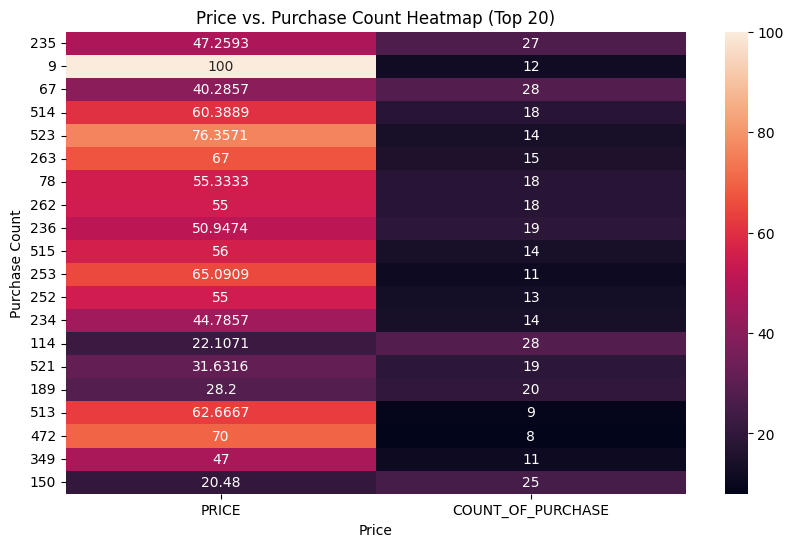

heatmap showing the correlation between price and purchase count for the top 20 items with the most purchase count


In [13]:
item_table = pd.merge(pd.merge(pd.merge(pd.merge(revenue_table, cart_count_table, on='item_id', how='outer'), view_count_table, on='item_id', how='outer'), purchase_count_table, on='item_id', how='outer'), item_price_table, on='item_id', how='outer')

item_table.fillna(0, inplace=True)

item_table = item_table.sort_values(by='Revenue', ascending=False)

item_table = item_table.rename(columns={'item_id': 'ITEM_ID', 'Revenue': 'REVENUE', 'added_to_cart_count': "ADD_TO_CART_COUNT", 'item_view_count': "ITEM_VIEW_COUNT", 'purchase_count': "COUNT_OF_PURCHASE", 'price': "PRICE"})
top_20_items = item_table.head(20)
plt.figure(figsize=(10, 6))
sns.heatmap(top_20_items[['PRICE', 'COUNT_OF_PURCHASE']], annot=True, fmt='g')
plt.xlabel('Price')
plt.ylabel('Purchase Count')
plt.title('Price vs. Purchase Count Heatmap (Top 20)')

plt.show()
print("heatmap showing the correlation between price and purchase count for the top 20 items with the most purchase count")

#### Problem 3: Correlation Between Number of Active Users and Revenue Question: Is there a correlation between the number of active users and the total revenue generated?

##### Statistical Test: Conduct a Pearson correlation coefficient to determine the strength and direction of the linear relationship between the number of active users and total revenue.

##### Data Visualization: Create a scatter plot with a regression line to visually represent the correlation between the number of active users and total revenue. Additionally, use a line chart with a rolling average to illustrate the trend over time.

In [14]:
query = """SELECT
    --Count the number of unique users
    COUNT(DISTINCT user_pseudo_id) AS Daily_Active_Users,
    --Convert the timestamp into DATE
    DATE(TIMESTAMP_MICROS(event_timestamp)) AS activity_date,
    --Aggregate the revenue column based on date
    sum(ecommerce.purchase_revenue_in_usd) as Revenue
FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
GROUP BY
    activity_date --group by date
ORDER BY
    activity_date; --order by date
"""

query_job = client.query(query)
result = query_job.result()
Daily_Active_Users = pd.DataFrame(result.to_dataframe())


In [15]:
query = """SELECT
    --Count the number of unique users
    COUNT(DISTINCT user_pseudo_id) AS Weekly_Active_Users,
    --Get the week number from date column
    EXTRACT(WEEK FROM DATE(TIMESTAMP_MICROS(event_timestamp))) AS Week,
    --Aggregate the sum of revenue by week
    sum(ecommerce.purchase_revenue_in_usd) as Revenue
FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
GROUP BY
    Week
ORDER BY
    Week;

"""

query_job = client.query(query)
result = query_job.result()
Weekly_Active_Users = pd.DataFrame(result.to_dataframe())


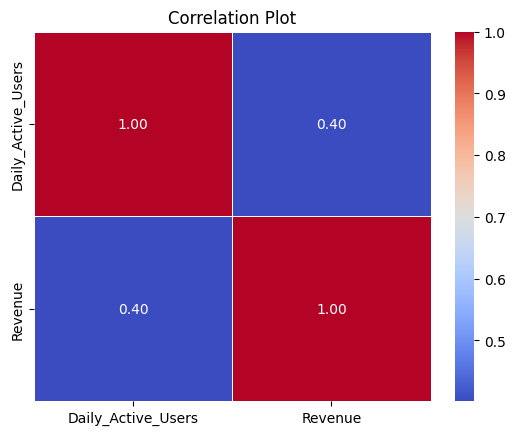

In [16]:
sns.heatmap(Daily_Active_Users[['Daily_Active_Users', 'Revenue']].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Show the plot
plt.title('Correlation Plot')
plt.show()

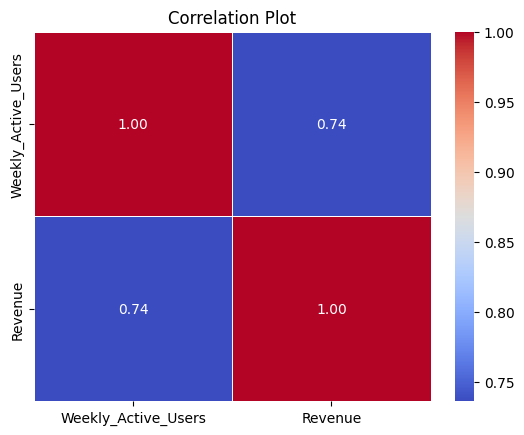

In [17]:
sns.heatmap(Weekly_Active_Users[['Weekly_Active_Users', 'Revenue']].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Show the plot
plt.title('Correlation Plot')
plt.show()

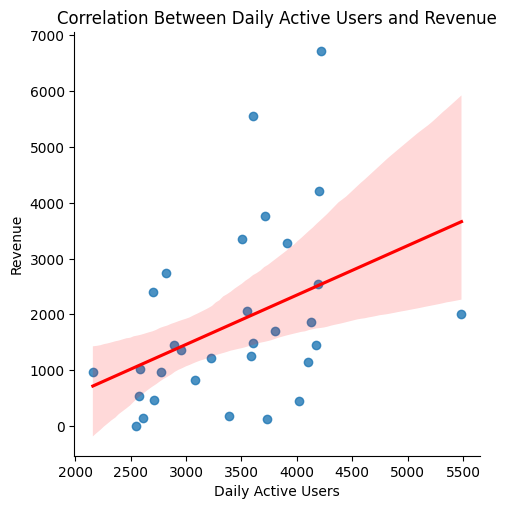

In [18]:
Daily_Active_Users['Daily_Active_Users'] = Daily_Active_Users['Daily_Active_Users'].astype(int)
Daily_Active_Users['Revenue'] = Daily_Active_Users['Revenue'].astype(int)

sns.lmplot(x='Daily_Active_Users', y='Revenue', data=Daily_Active_Users, line_kws={'color': 'red'})
plt.title('Correlation Between Daily Active Users and Revenue')
plt.xlabel('Daily Active Users')
plt.ylabel('Revenue')
plt.show()


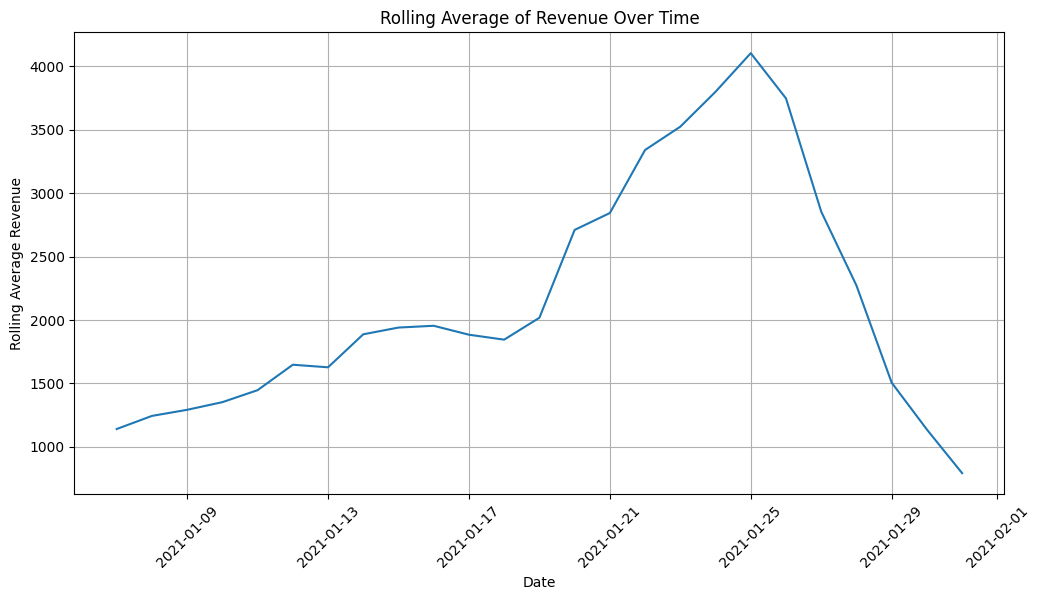

In [19]:
rolling_average = Daily_Active_Users['Revenue'].rolling(window=7).mean()
plt.figure(figsize=(12, 6))
plt.plot(Daily_Active_Users['activity_date'], rolling_average)
plt.title('Rolling Average of Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Rolling Average Revenue')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### Problem 4: Influence of User Engagement Time on Conversion Rate Question: Does the time spent by users engaging with the platform influence the conversion rate?

##### Statistical Test: Perform a regression analysis to assess impact of relevant variables on the conversion rate.

##### Data Visualization: Generate a scatter plot with a regression line to depict the relationship between user engagement time and conversion rate. Additionally, use a line chart with a rolling average to visualize trends in the impact of engagement time on conversion rate over time.

In [20]:
query = """WITH active_users as (SELECT
  count(user_pseudo_id) as total_number_of_users,
  DATE(TIMESTAMP_MICROS(event_timestamp)) AS activity_date,
  sum(event_params.value.int_value) AS total_engagement_time,
FROM
  `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`,
  UNNEST(event_params) AS event_params
WHERE
  event_params.key = 'engagement_time_msec'
  and event_name in ('user_engagement') --users who were actively engaged
group by activity_date
order by activity_date),

purchase_users AS (SELECT
  COUNT(user_pseudo_id) AS number_of_users_bought,
  DATE(TIMESTAMP_MICROS(event_timestamp)) AS activity_date,
  SUM(event_params.value.int_value) AS engagement_time_of_purchasing_users,
  SUM(ecommerce.purchase_revenue_in_usd) AS Revenue
  FROM
  `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`,
  UNNEST(event_params) AS event_params
WHERE
  event_params.key = 'engagement_time_msec'
  AND event_name IN ('purchase')
GROUP BY
  activity_date
ORDER BY
  activity_date
)
SELECT a.total_number_of_users AS TOTAL_NUMBER_OF_ACTIVE_USERS, p.number_of_users_bought AS NUMBER_OF_USERS_PURCHASED, p.activity_date AS ACTIVITY_DATE, p.Revenue AS REVENUE, a.total_engagement_time AS TOTAL_USERS_ENGAGEMENT_TIME, p.engagement_time_of_purchasing_users AS PURCHASING_USERS_ENGAGEMENT_TIME, ROUND((p.number_of_users_bought/a.total_number_of_users)*100, 3) AS CONVERSION_RATE
FROM purchase_users p
LEFT JOIN active_users a ON p.activity_date=a.activity_date
ORDER BY REVENUE DESC;
"""

query_job = client.query(query)
result = query_job.result()
engagement_table = pd.DataFrame(result.to_dataframe())


In [21]:
engagement_table.head(5)

,TOTAL_NUMBER_OF_ACTIVE_USERS,NUMBER_OF_USERS_PURCHASED,ACTIVITY_DATE,REVENUE,TOTAL_USERS_ENGAGEMENT_TIME,PURCHASING_USERS_ENGAGEMENT_TIME,CONVERSION_RATE
0,14064,89,2021-01-20,5926.0,208566703,608,0.633
1,10023,94,2021-01-22,5271.0,111938555,666,0.938
2,11082,49,2021-01-21,3935.0,151821982,364,0.442
3,10951,43,2021-01-19,3541.0,155899892,305,0.393
4,8037,55,2021-01-25,3140.0,141067014,329,0.684


In [22]:
import statsmodels.api as sm

X = engagement_table[["TOTAL_NUMBER_OF_ACTIVE_USERS",	"NUMBER_OF_USERS_PURCHASED", "TOTAL_USERS_ENGAGEMENT_TIME", "PURCHASING_USERS_ENGAGEMENT_TIME"]]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Define the dependent variable (response variable)
y = engagement_table['REVENUE']

# Fit the linear regression model
model = sm.OLS(y, X.astype(float)).fit()

# Print the summary of the regression
print(model.summary())
print(f"""TOTAL_NUMBER_OF_ACTIVE_USERS: -0.4432, having a negative relationship between the total number of active users and revenue. and being
statistically significant.
NUMBER_OF_USERS_PURCHASED: -9.3552, the variable being statistically insignificat so why bother an explanation. 🤷‍♂️
TOTAL_USERS_ENGAGEMENT_TIME: 4.016e-05, the coefficient is too small to bother. AGAIN!
PURCHASING_USERS_ENGAGEMENT_TIME: 8.7810, Now this is what we call significant variable! You can interpret it yourself 🤣
""")

                            OLS Regression Results                            
Dep. Variable:                REVENUE   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     27.55
Date:                Tue, 09 Jan 2024   Prob (F-statistic):           5.15e-09
Time:                        12:13:15   Log-Likelihood:                -243.62
No. Observations:                  31   AIC:                             497.2
Df Residuals:                      26   BIC:                             504.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

<center>

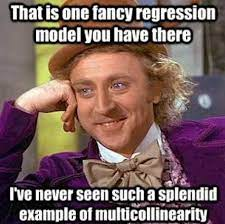

<center>

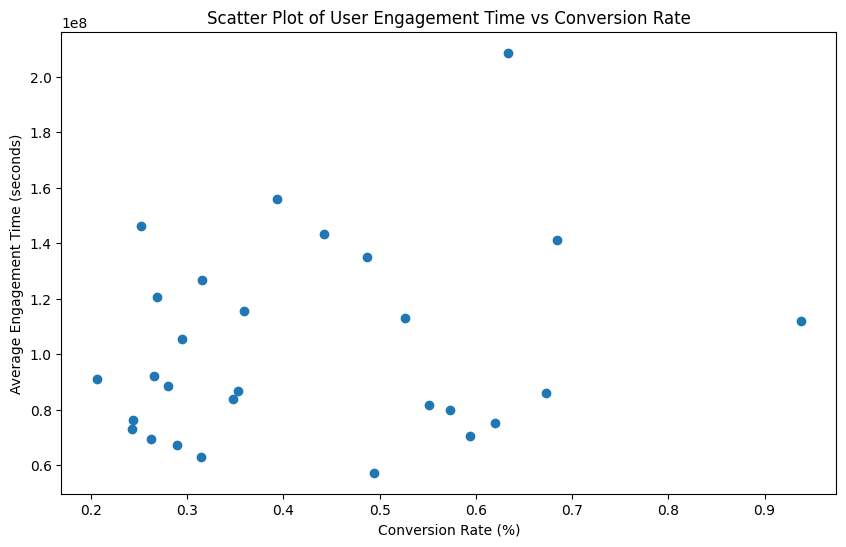

In [23]:
average_engagement = engagement_table.groupby('CONVERSION_RATE')['TOTAL_USERS_ENGAGEMENT_TIME'].mean()

average_engagement = average_engagement.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.scatter(average_engagement.index, average_engagement.values)

plt.xlabel('Conversion Rate (%)')
plt.ylabel('Average Engagement Time (seconds)')
plt.title('Scatter Plot of User Engagement Time vs Conversion Rate')

plt.show()

#### Problem 5: Does campaigns like coupons/promotions bring revenue?


In [24]:
query = """SELECT
  --name of the campaign/where users got the promotion from
  event_params.value.string_value as NAME_OF_ADVERTIDEMENT,
  --total number of each promotions/source
  count(event_params.value.string_value) AS NUMBER_OF_USERS_GENERATED,
  --Sum of revenue from each promotion
  sum(ecommerce.purchase_revenue_in_usd) as REVENUE
FROM
  `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`,
  UNNEST(event_params) AS event_params --unnest the array
WHERE
  event_params.key = 'campaign'
GROUP BY NAME_OF_ADVERTIDEMENT
ORDER BY REVENUE DESC;
"""

query_job = client.query(query)
result = query_job.result()
advertisement_table = pd.DataFrame(result.to_dataframe())
advertisement_table.fillna(0, inplace=True)


In [25]:
advertisement_table

,NAME_OF_ADVERTIDEMENT,NUMBER_OF_USERS_GENERATED,REVENUE
0,(referral),186809,38336.0
1,(organic),89511,7148.0
2,(direct),28697,4669.0
3,<Other>,23511,4188.0
4,(data deleted),6199,1301.0
5,Data Share Promo,1381,0.0
6,NewYear_V2,79,0.0
7,BlackFriday_V1,3,0.0
8,Holiday_V1,1,0.0
9,NewYear_V1,149,0.0


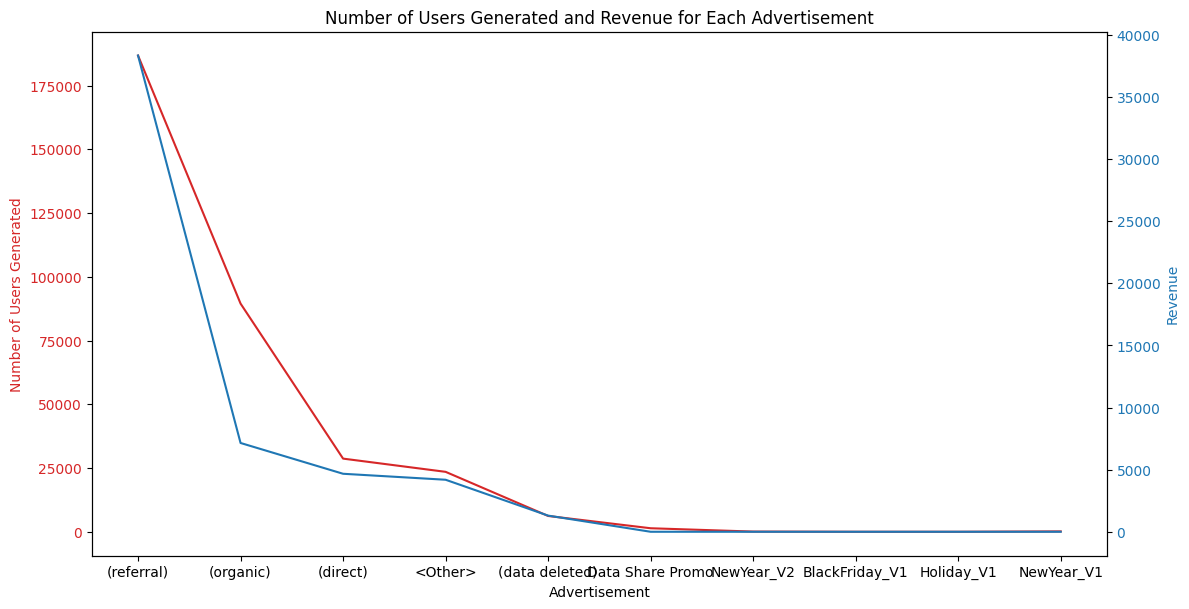

In [26]:

fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Advertisement')
ax1.set_ylabel('Number of Users Generated', color=color)
ax1.plot(advertisement_table['NAME_OF_ADVERTIDEMENT'], advertisement_table['NUMBER_OF_USERS_GENERATED'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Revenue', color=color)
ax2.plot(advertisement_table['NAME_OF_ADVERTIDEMENT'], advertisement_table['REVENUE'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Number of Users Generated and Revenue for Each Advertisement')
plt.show()


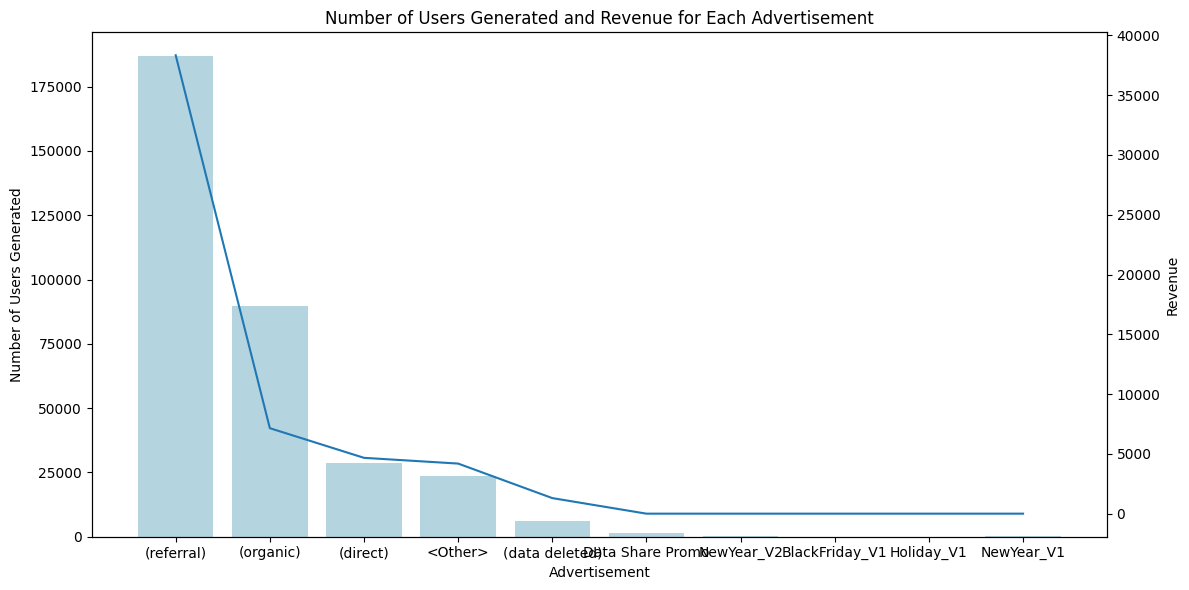

In [27]:
plt.figure(figsize=(12, 6))
sns.barplot(x='NAME_OF_ADVERTIDEMENT', y='NUMBER_OF_USERS_GENERATED', data=advertisement_table, color='lightblue')
plt.xlabel('Advertisement')
plt.ylabel('Number of Users Generated')

ax2 = plt.twinx()
sns.lineplot(x='NAME_OF_ADVERTIDEMENT', y='REVENUE', data=advertisement_table, color='tab:blue', ax=ax2)
ax2.set_ylabel('Revenue')

plt.title('Number of Users Generated and Revenue for Each Advertisement')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

#### Problem 6: Geographic Question

##### Statistical Test:

##### Data Visualization:

In [28]:
sql_query = """
     -- Selecting aggregated information about user purchases with additional details.
SELECT
    -- Renaming the 'user_pseudo_id' column to 'USER_ID'.
    user_pseudo_id AS USER_ID,
    -- Summing the purchase revenue in USD for each user and renaming the column to 'PURCHASE_AMOUNT.'
    SUM(ecommerce.purchase_revenue_in_usd) AS PURCHASE_AMOUNT,
    -- Selecting the sub-continent from the 'geo' field.
    geo.sub_continent AS SUB_CONTINENT,
    -- Selecting the mobile brand name from the 'device' field.
    device.mobile_brand_name AS MOBILE_BRAND,
    -- Selecting the platform.
    platform AS PLATFORM
FROM
    -- Selecting data from the GA4 obfuscated sample e-commerce dataset for January 2021.
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
WHERE
    -- Filtering the rows to include only those with non-null purchase revenue.
    ecommerce.purchase_revenue_in_usd IS NOT NULL
GROUP BY
    -- Grouping the results by user ID, sub-continent, mobile brand, and platform.
    user_pseudo_id, geo.sub_continent, device.mobile_brand_name, platform;
"""


query_job = client.query(sql_query)
result = query_job.result()

geographic_table = pd.DataFrame(result.to_dataframe())



In [29]:
geographic_table['PURCHASED'] = 0
for i in range(len(geographic_table)):
  if geographic_table.loc[i, 'PURCHASE_AMOUNT']>0:
    geographic_table.loc[i, 'PURCHASED'] = 1

continent_mapping = {
    'Australasia': 'Oceania',
    'Caribbean': 'North America',
    'Central America': 'North America',
    'Eastern Africa': 'Africa',
    'Eastern Asia': 'Asia',
    'Eastern Europe': 'Europe',
    'Northern Africa': 'Africa',
    'Northern America': 'North America',
    'Northern Europe': 'Europe',
    'South America': 'South America',
    'Southeast Asia': 'Asia',
    'Southern Africa': 'Africa',
    'Southern Asia': 'Asia',
    'Southern Europe': 'Europe',
    'Western Asia': 'Asia',
    'Western Europe': 'Europe'
}

geographic_table['continent'] = geographic_table['SUB_CONTINENT'].map(continent_mapping)



geographic_table

#IF YOU WANT TO CHECK WHICH USER Still have duplicate and reason Uncomment the following code and run
# p = pd.DataFrame(geographic_table['USER_ID'].value_counts()).reset_index()
# users_table[geographic_table['USER_ID'].isin(list(p[p['USER_ID']>1]['index']))]

,USER_ID,PURCHASE_AMOUNT,SUB_CONTINENT,MOBILE_BRAND,PLATFORM,PURCHASED,continent
0,2459937.2318206302,63.0,Eastern Asia,Google,WEB,1,Asia
1,2637438.5895621403,18.0,Southern Europe,Apple,WEB,1,Europe
2,2838161.4781702653,21.0,Northern America,Samsung,WEB,1,North America
3,3056927.8375951035,61.0,Northern America,Apple,WEB,1,North America
4,32591508.2385963314,48.0,Caribbean,Google,WEB,1,North America
...,...,...,...,...,...,...,...
1069,4229717.4815659011,209.0,Southeast Asia,Google,WEB,1,Asia
1070,68948805.5649073366,97.0,Southern Asia,Apple,WEB,1,Asia
1071,40652857.6013892710,300.0,Western Europe,Google,WEB,1,Europe
1072,7581292.6376201300,104.0,Western Europe,Apple,WEB,1,Europe


In [30]:
continent_data = geographic_table.groupby('continent')['PURCHASE_AMOUNT'].sum().reset_index()
continent_data

,continent,PURCHASE_AMOUNT
0,Africa,103.0
1,Asia,13461.0
2,Europe,10865.0
3,North America,29899.0
4,Oceania,909.0
5,South America,1991.0


In [31]:
geographic_table.groupby(geographic_table["PLATFORM"])["PURCHASE_AMOUNT"].sum().reset_index()

,PLATFORM,PURCHASE_AMOUNT
0,WEB,57350.0


In [32]:
geographic_table.groupby(geographic_table["MOBILE_BRAND"])["PURCHASE_AMOUNT"].sum().reset_index()

,MOBILE_BRAND,PURCHASE_AMOUNT
0,<Other>,5019.0
1,Apple,24752.0
2,Google,18626.0
3,Huawei,907.0
4,Microsoft,691.0
5,Mozilla,420.0
6,Samsung,4418.0
7,Xiaomi,2517.0


In [33]:
geographic_table.groupby(geographic_table["PURCHASED"])["PURCHASE_AMOUNT"].count().reset_index()

,PURCHASED,PURCHASE_AMOUNT
0,0,254
1,1,820


In [34]:
continent_data

,continent,PURCHASE_AMOUNT
0,Africa,103.0
1,Asia,13461.0
2,Europe,10865.0
3,North America,29899.0
4,Oceania,909.0
5,South America,1991.0


In terms of revenue ranking, North America stands out as the leading continent, contributing the highest purchase amount. Asia follows closely behind, showcasing a robust economic presence. Europe secures the third position, reflecting substantial revenue from purchases. South America and Oceania contribute moderately to the overall revenue, while Africa, while ranking lowest, still adds a noteworthy amount to the global purchase revenue.

These insights are valuable for businesses to understand the geographical distribution of their revenue and tailor marketing and sales strategies based on the performance of each continent

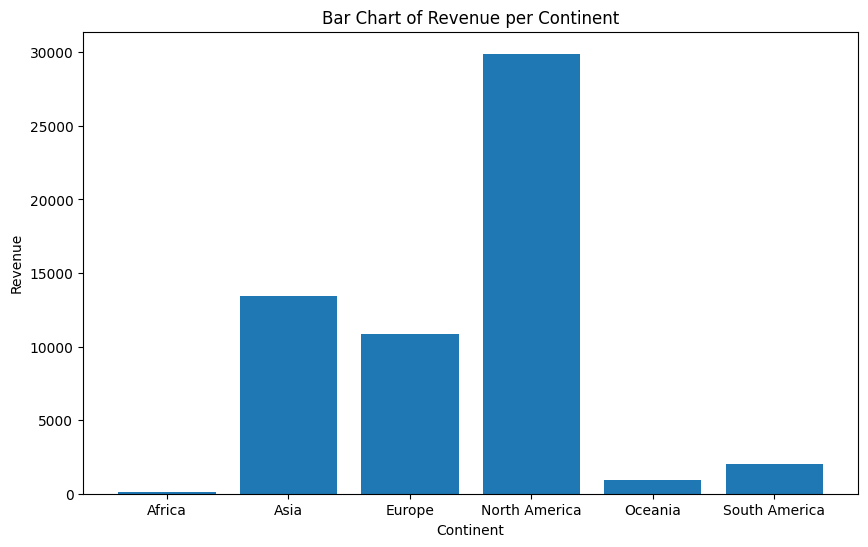

In [35]:
conti = geographic_table.groupby('continent')['PURCHASE_AMOUNT'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(conti['continent'], conti['PURCHASE_AMOUNT'])

plt.xlabel('Continent')
plt.ylabel('Revenue')
plt.title('Bar Chart of Revenue per Continent')
plt.show()

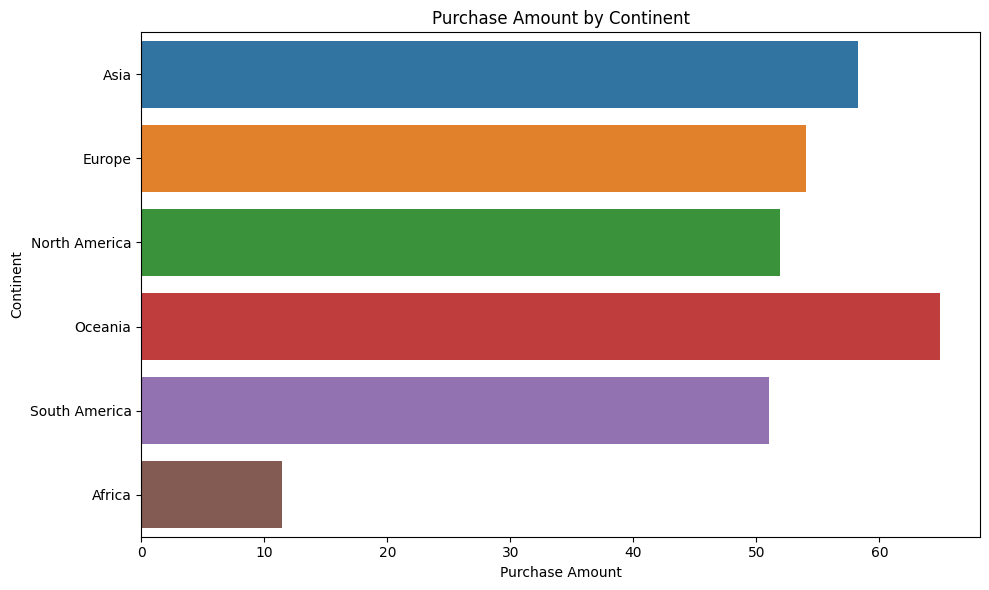

In [36]:
plt.figure(figsize=(10, 6))
sns.barplot(x='PURCHASE_AMOUNT', y='continent', data=geographic_table, ci=None)
plt.xlabel('Purchase Amount')
plt.ylabel('Continent')
plt.title('Purchase Amount by Continent')
plt.tight_layout()
plt.show()

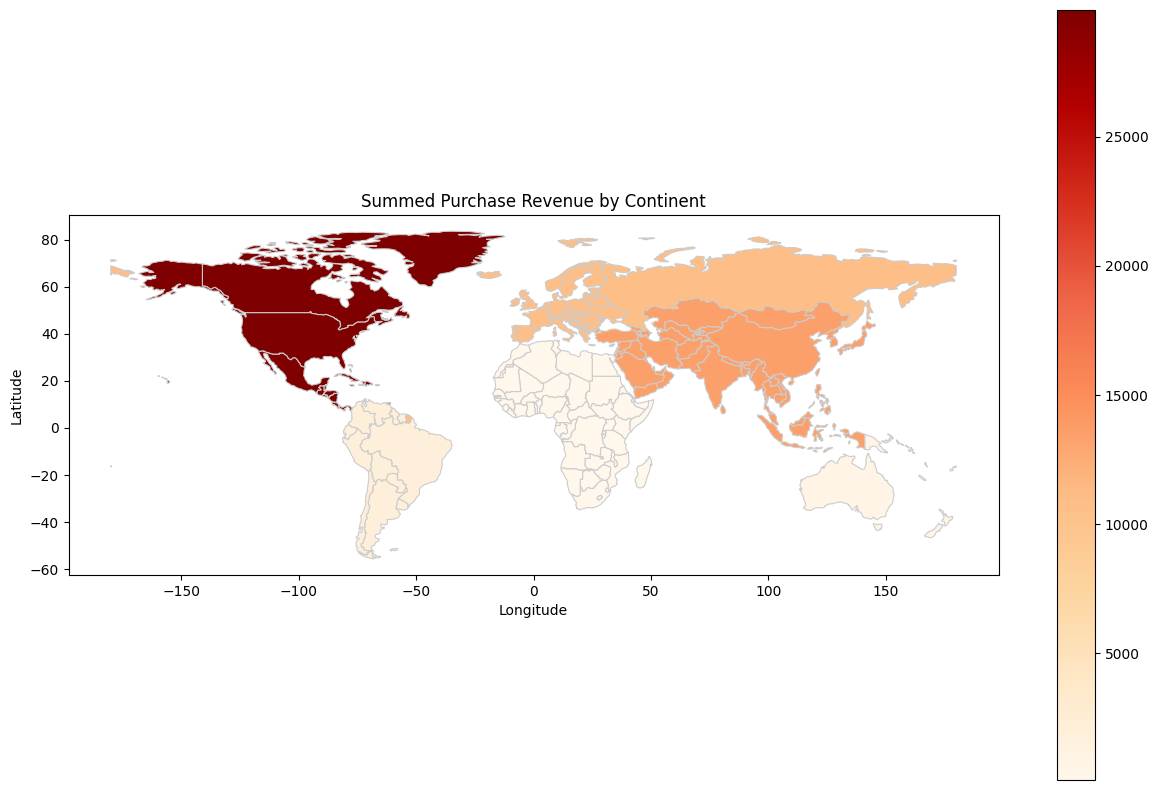

In [37]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

merged = world.merge(continent_data, how='left', left_on='continent', right_on='continent')

fig, ax = plt.subplots(figsize=(15, 10))
merged.plot(column='PURCHASE_AMOUNT', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

plt.title('Summed Purchase Revenue by Continent')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()
